In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# load CIFA-10 data
train_dataset = torchvision.datasets.CIFAR10(
      root='./data/',
      train=True,
      transform=transforms.ToTensor(),
      download=True)

test_dataset = torchvision.datasets.CIFAR10(
      root='./data/',
      train=False,
      transform=transforms.ToTensor(),
      download=True)

print ('train_dataset = ', len(train_dataset))
print ('test_dataset = ', len(test_dataset))
image, label = train_dataset[0]
print (image.size())

100%|██████████| 170498071/170498071 [00:04<00:00, 38552523.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
train_dataset =  50000
test_dataset =  10000
torch.Size([3, 32, 32])


In [5]:
# set data loader
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=64,
      shuffle=True,
      num_workers=2)

test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=64,
      shuffle=False,
      num_workers=2)

In [9]:
# Alexnet

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

# select device
num_classes = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
# training
num_epochs = 10
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

### training
for epoch in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    # ====== train_mode ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ====== val_mode ======
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/10], Loss: 0.0270, val_loss: 0.0219, val_acc: 0.4759
Epoch [2/10], Loss: 0.0209, val_loss: 0.0189, val_acc: 0.5632
Epoch [3/10], Loss: 0.0184, val_loss: 0.0175, val_acc: 0.6000
Epoch [4/10], Loss: 0.0166, val_loss: 0.0164, val_acc: 0.6314
Epoch [5/10], Loss: 0.0153, val_loss: 0.0154, val_acc: 0.6549
Epoch [6/10], Loss: 0.0143, val_loss: 0.0147, val_acc: 0.6805
Epoch [7/10], Loss: 0.0134, val_loss: 0.0141, val_acc: 0.6872
Epoch [8/10], Loss: 0.0125, val_loss: 0.0151, val_acc: 0.6745
Epoch [9/10], Loss: 0.0118, val_loss: 0.0134, val_acc: 0.7059
Epoch [10/10], Loss: 0.0114, val_loss: 0.0135, val_acc: 0.7062


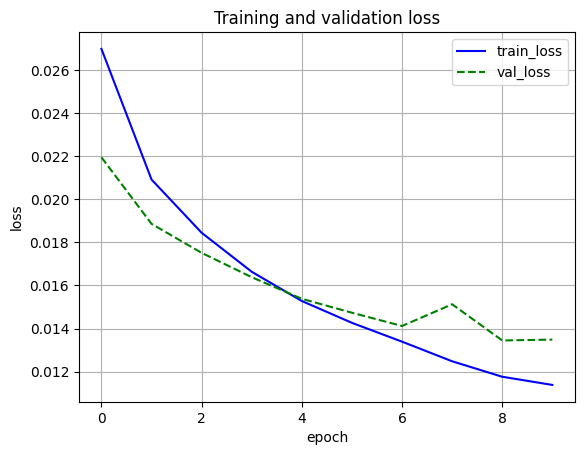

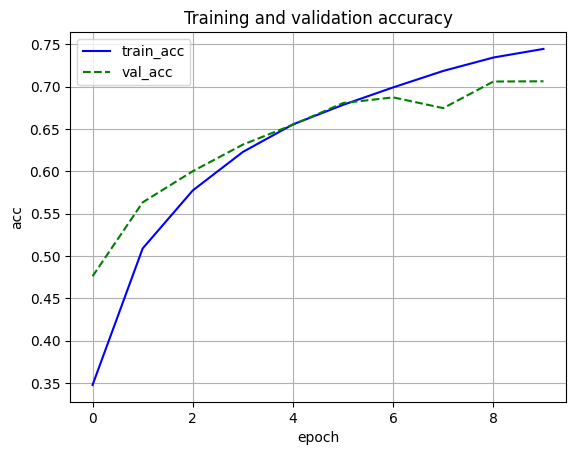

In [12]:
# plot graph
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()